# HW03: Embeddings

In [1]:
# Import Libraries
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from gensim import models
    from gensim import similarities
except:
    !pip install gensim=3.8
    from gensim import models
    from gensim import similarities
    
try:
    import seaborn as sn
except:
    !pip install seaborn
    import seaborn as sn

try:
    from sklearn.decomposition import PCA
except:
    !pip install sklearn
    from sklearn.decomposition import PCA

## Simpsons Dataset

### Import training data

In [2]:
# Import data
simpsons_docs = []

# Open and read file
with open('./data/simpsons/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        simpsons_docs.append(row)
        
# Glimpse at training docs
for i in range(0,10):
    print(simpsons_docs[i])

['lisa', 'i', 'will', 'do', 'the', 'dish', 'when', 'i', 'pick', 'it', 'out', 'of', 'the', 'chore', 'hat', 'and', 'it', 'is', 'not', 'a', 'practice', 'see', 'there', 'it', 'is', 'but', 'that', 'wa', 'a', 'practice', 'the', 'system', 'work']
['do', 'not', 'worry', 'i', 'have', 'got', 'a', 'man', 'on', 'the', 'perimeter']
['snowball']
['oh', 'yeah', 'you', 'were', 'way', 'off']
['oh', 'it', 'is', 'beautiful', 'oh', 'oh', 'let', 'u', 'put', 'bart', 's', 'beautiful', 'drawing', 'up', 'on', 'the', 'fridge']
['you', 're', 'halfway', 'home', 'lady']
['uh', 'hello']
['i', 'got', 'the', 'idea', 'from', 'the', 'regular', 'pen']
['you', 'cannot', 'teach', 'this', 'way']
['heh', 'heh', 'heh', 'moe', 'is', 'their', 'leader']


### Word2Vec Embeddings

In [3]:
# Define Word2Vec Embeddings
simpsons_w2v_model_150 = models.Word2Vec(simpsons_docs, size=150, window=2, min_count=10, sg=0, negative=10, workers=10)
simpsons_w2v_model_75 = models.Word2Vec(simpsons_docs, size=75, window=2, min_count=10, sg=0, negative=10, workers=10)
simpsons_w2v_model_15 = models.Word2Vec(simpsons_docs, size=15, window=2, min_count=10, sg=0, negative=10, workers=10)

# Train Word2Vec Embeddings
simpsons_w2v_model_150.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)
simpsons_w2v_model_75.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)
simpsons_w2v_model_15.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=10)

(2887187, 4505780)

In [4]:
# Save W2V Embeddings
simpsons_w2v_model_150.save("./resources/embeddings/Simpsons_150_7.model")
simpsons_w2v_model_75.save("./resources/embeddings/Simpsons_75_7.model")
simpsons_w2v_model_15.save("./resources/embeddings/Simpsons_15_7.model")

In [5]:
len(simpsons_w2v_model_150.wv.vocab)

2754

### 2D Plots

In [6]:
def plot_similar_words(words, model, subplot_size = [2,2], xlim=[-5,5], ylim=[-5,5], file_name='sim_words'):
    """ Plot a 2D proyection of the embeddings for the most similar words from param.
    
    Args:
        words (str): List of words to be ploted.
        model (gensim.models.word2vec): Trained word2vec model.
        subplot_size (tuple): Subplot size.
        xlim (tuple): x axis lims.
        ylim (tuple): y axis lims.
        file_name (str): name of saved png file.
    
    """
    
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle('Most similar words to:', fontsize=20)
    
    # Loop over the words
    for i, word in enumerate(words):
        
        # Retrieve similar words
        most_similar = model.wv.most_similar(positive=[word])

        similar_words = [word]
        for w in most_similar:
            similar_words.append(w[0])

        # Create PCA object with 2 components
        pca = PCA(n_components=2)

        # Extract embeddings from model
        vocab = list(model.wv.vocab)
        X = model.wv[vocab]

        # Fit PCA with all embeddings vocab
        pca.fit(X)

        # Transform similar words
        X_pca = pca.transform(model.wv[similar_words])

        # Plot
        df = pd.DataFrame(X_pca, index=similar_words, columns=['x', 'y'])
        
        plt.subplot(subplot_size[0], subplot_size[1], i+1)
        plt.title(str(word), fontsize=18)
        plt.grid(True)
        plt.xlim(xlim)
        plt.ylim(ylim)

        plt.scatter(df['x'], df['y'], s=100, c='b', alpha=0.25)
        plt.scatter(df['x'][0], df['y'][0], s=100, c='r', alpha=0.25)
        for word, pos in df.iterrows():
            plt.annotate(word, pos, fontsize=11)
            
        plt.savefig(f'./results/embeddings/{file_name}')


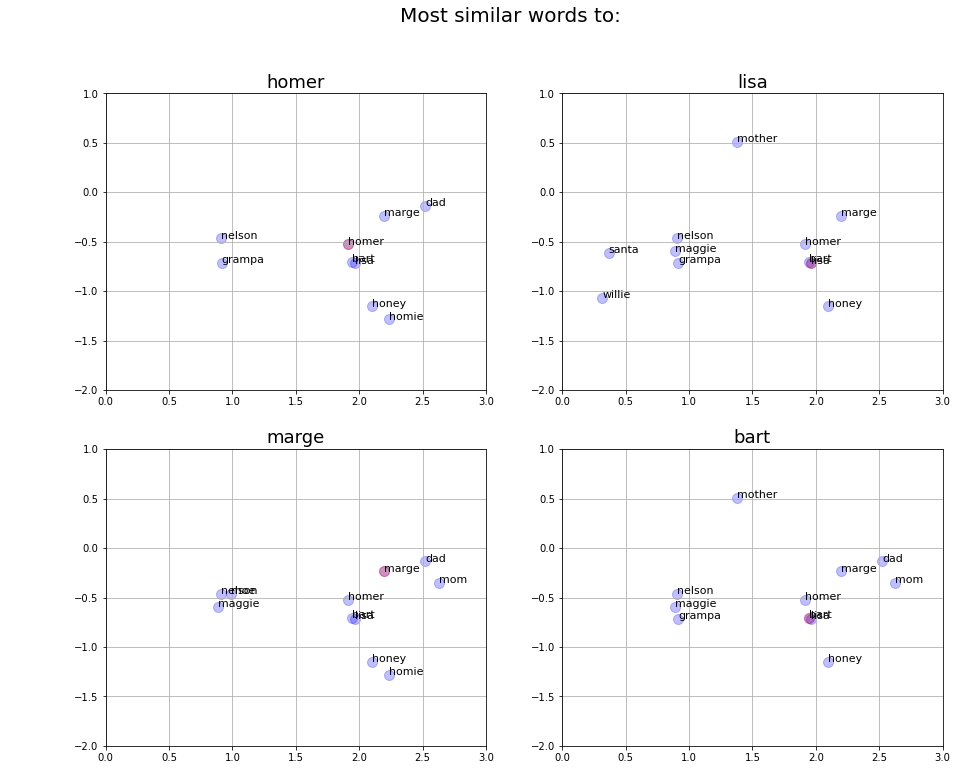

In [43]:
simpsons_characters = ['homer', 'lisa', 'marge', 'bart']
plot_similar_words(simpsons_characters, simpsons_w2v_model_75, 
                   subplot_size = [2,2], xlim=[0,3], ylim=[-2,1], 
                   file_name='simpsons_similar_75')

### Relations

#### Similarity

How similar are two words?

In [8]:
def get_similarity_matrix(w2v_model, word_list):
    """ Computes all similarities between words in word_list array.
    
    Args:
        model (gensim.models.word2vec): Trained word2vec model
        word_list (str): list of words to be compared.
    
    Returns:
        matrix(np.array): Similarities matrix between all wards.
    
    """
    
    # Init matrix
    matrix = np.zeros((len(word_list),len(word_list)))
    
    # Get similarity between all words
    for i, wi in enumerate(word_list):
        for j, wj in enumerate(word_list):
            matrix[i][j] = w2v_model.wv.similarity(wi, wj)
            
    return matrix

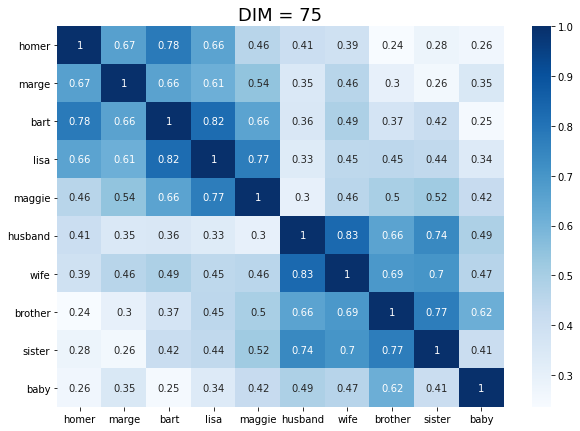

In [62]:
# Get similarity matrix
word_list = ['homer', 'marge', 'bart', 'lisa', 'maggie', 'husband', 'wife', 'brother', 'sister', 'baby']
sim_matrix = get_similarity_matrix(simpsons_w2v_model_75, word_list)

# Plot matrix
sim_df = pd.DataFrame(sim_matrix, index = [i for i in word_list],columns = [i for i in word_list])
plt.figure(figsize = (10,7))
plt.title('DIM = 75', fontsize=18)
sim_heatmap = sn.heatmap(sim_df, annot=True, cmap='Blues')

# Save figure
figure = sim_heatmap.get_figure()    
figure.savefig('./results/embeddings/simpsons_matrix_75.png')

#### Analogy

Which word is to $w_4$ as $w_1$ is to $w_2$?

In [10]:
simpsons_w2v_model_75.wv.most_similar(positive=["brother", "bart"], negative=['lisa'], topn=5)

[('sister', 0.6853569746017456),
 ('child', 0.6722093820571899),
 ('ear', 0.6715455055236816),
 ('wife', 0.6709880828857422),
 ('daughter', 0.6523621082305908)]

In [11]:
simpsons_w2v_model_75.wv.most_similar(positive=["husband", "homer"], negative=['marge'], topn=5)

[('daughter', 0.6058991551399231),
 ('hero', 0.5935206413269043),
 ('brain', 0.5808199644088745),
 ('girlfriend', 0.5769661664962769),
 ('voice', 0.5721878409385681)]

In [12]:
simpsons_w2v_model_150.wv.most_similar(positive=["murder", "bob"], negative=['krusty'], topn=5)

[('guilty', 0.5553858280181885),
 ('worth', 0.5426217317581177),
 ('boyfriend', 0.5345817804336548),
 ('tale', 0.5330238938331604),
 ('plain', 0.5322700142860413)]

#### Doesn't Match

Which word doesn't match?

In [49]:
simpsons_w2v_model_150.wv.doesnt_match(['homer', 'lisa', 'krusty', 'bart', 'marge'])

'krusty'

In [14]:
simpsons_w2v_model_150.wv.doesnt_match(['nelson', 'bart', 'milhouse', 'skinner'])

'skinner'

In [15]:
simpsons_w2v_model_150.wv.doesnt_match(['carl', 'lenny', 'ralph'])

'ralph'

In [48]:
simpsons_w2v_model_15.wv.doesnt_match(['clancy', 'lou', 'eddie', 'bob'])

'bob'

## Friends Dataset

### Import Data

In [17]:
# Import data
friends_docs = []

# Open and read file
with open('./data/friends/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        friends_docs.append(row)
        
# Glimpse at training docs
for i in range(0,5):
    print(friends_docs[i])

['okay', 'okay', 'i', 'll', 'tell', 'em', 'it', 'wasn', 't', 'chandler', 'who', 'got', 'high', 'now', 'who', 'should', 'i', 'say', 'it', 'wa']
['no']
['oh', 'you', 'do', 'not', 'want', 'me', 'on', 'the', 'trip']
['my', 'oh', 'my', 'god']
['nooo', 'but', 'it', 'but', 'it', 's', 'great']


### Word2Vec Embeddings

In [18]:
# Define Word2Vec Embeddings
friends_w2v_model_150 = models.Word2Vec(friends_docs, size=150, window=2, min_count=10, sg= 0, negative=10, workers=10)
friends_w2v_model_75 = models.Word2Vec(friends_docs, size=75, window=2, min_count=10, sg= 0, negative=10, workers=10)
friends_w2v_model_15 = models.Word2Vec(friends_docs, size=15, window=2, min_count=10, sg= 0, negative=10, workers=10)

# Train Word2Vec Embeddings
friends_w2v_model_150.train(friends_docs, total_examples=len(friends_docs), epochs=10)
friends_w2v_model_75.train(friends_docs, total_examples=len(friends_docs), epochs=10)
friends_w2v_model_15.train(friends_docs, total_examples=len(friends_docs), epochs=10)

(2567254, 4089210)

In [19]:
# Save W2V Embeddings
friends_w2v_model_150.save("./resources/embeddings/Friends_150_7.model")
friends_w2v_model_75.save("./resources/embeddings/Friends_75_7.model")
friends_w2v_model_15.save("./resources/embeddings/Friends_15_7.model")

In [20]:
len(friends_w2v_model_150.wv.vocab)

2017

### 2D Plots

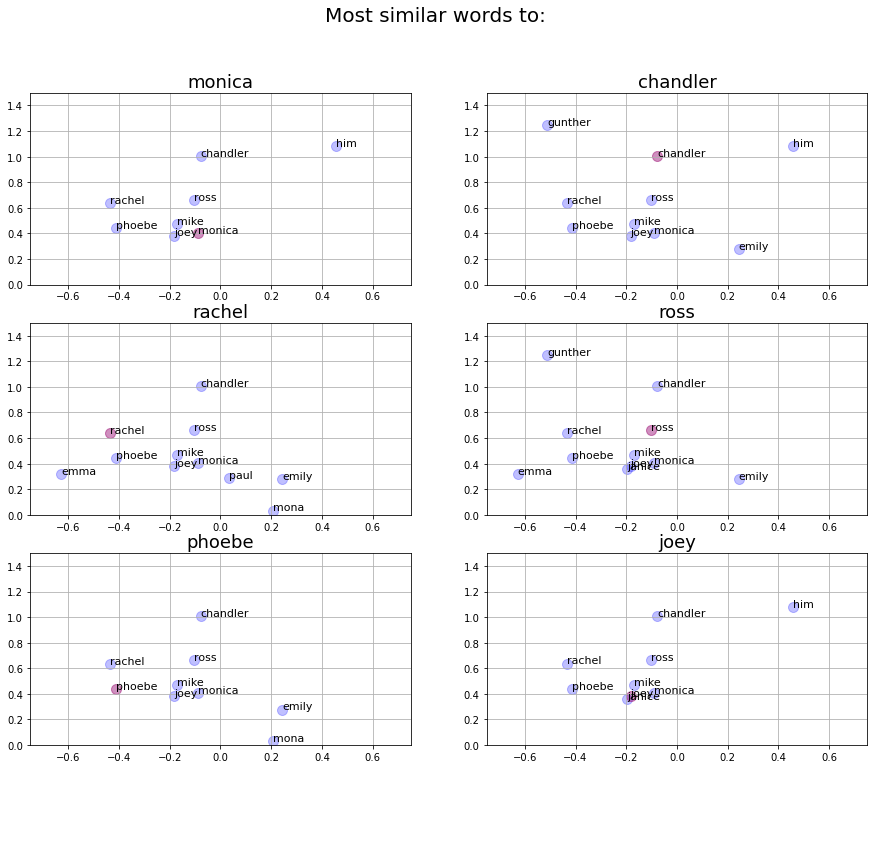

In [35]:
friends_characters = ['monica', 'chandler', 'rachel', 'ross', 'phoebe', 'joey']
plot_similar_words(friends_characters, friends_w2v_model_150, 
                   subplot_size = [3,2], xlim=[-0.75,0.75], ylim=[0,1.5],
                   file_name='friends_similar_150')

### Relations

#### Similarity

How similar are two words?

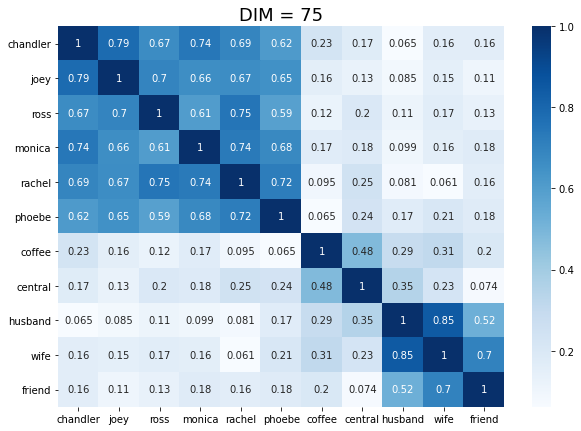

In [59]:
# Get similarity matrix
word_list = ['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'coffee', 'central','husband', 'wife', 'friend']
sim_matrix = get_similarity_matrix(friends_w2v_model_75, word_list)

# Plot matrix
sim_df = pd.DataFrame(sim_matrix, index = [i for i in word_list],columns = [i for i in word_list])
plt.figure(figsize = (10,7))
plt.title('DIM = 75', fontsize=18)
sim_heatmap = sn.heatmap(sim_df, annot=True, cmap='Blues')

# Save figure
figure = sim_heatmap.get_figure()    
figure.savefig('./results/embeddings/friends_matrix_75.png')

#### Analogy

Which word is to $w_4$ as $w_1$ is to $w_2$?

In [31]:
friends_w2v_model_150.wv.most_similar(positive=["wife", "rachel"], negative=['husband'], topn=5)

[('ross', 0.7106773853302002),
 ('chandler', 0.665300190448761),
 ('monica', 0.6618688106536865),
 ('mike', 0.6021301746368408),
 ('phoebe', 0.6005862355232239)]

In [24]:
friends_w2v_model_15.wv.most_similar(positive=["woman", "monica"], negative=['boy'], topn=5)

[('chandler', 0.8313519954681396),
 ('rachel', 0.7881670594215393),
 ('someone', 0.7686854600906372),
 ('mike', 0.7565426826477051),
 ('joey', 0.7157042026519775)]

#### Doesn't Match

Which word doesn't match?

In [25]:
friends_w2v_model_150.wv.doesnt_match(['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'janice'])

C:\Users\CESAR\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'janice'

In [26]:
friends_w2v_model_150.wv.doesnt_match(['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'gunther'])

'gunther'